<a href="https://colab.research.google.com/github/emivlp/Pyspark_SparkSQL/blob/main/pyspark_covid19_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID-19 Data Analysis with PySpark: EDA, Feature Engineering & Time-Series Modeling**

## **1. Introduction**
The **OWID COVID-19** dataset, maintained by [Our World in Data](https://github.com/owid/covid-19-data), is a **comprehensive global source of daily COVID-19** metrics: cases, deaths, tests, vaccinations, and more. This dataset enables us to analyze the progression of the pandemic on a global scale.

In this notebook, our objective is to build a robust analysis pipeline using **PySpark**. Our workflow includes:

- **Load and inspect** the dataset using **PySpark** for large-scale data analysis.
- Perform **exploratory data analysis (EDA)**, by using both DataFrame operations and Spark SQL. This includes filtering, grouping, and computing descriptive statistics to understand data quality and trends.
- Develop **feature engineering** steps to enrich the dataset with derived metrics such as the case fatality ratio (the ratio of total deaths to total cases per million) and the vaccinated ratio (the fraction of the population that is fully vaccinated). These features help reveal underlying relationships within the data.
- Build **visualizations** by converting Spark DataFrames to Pandas DataFrames. We create various plots including bar charts, correlation matrices, and, importantly, **time-series analyses** that compare actual daily new cases to the predictions of our classification model.
- **Training a binary classification model** (using Logistic Regression) to determine whether a given day’s new COVID-19 cases exceed 1000. In this model, days with more than **1000 new cases** are labeled as 1 (indicating a surge), while all other days are labeled as 0.

## **Time-Series Analysis in Our Workflow**

An essential part of our analysis is the time-series evaluation of our model's predictions. After training the classifier, we join the model’s binary predictions with the original time-series data. This enables us to:

- **Plot Actual vs. Predicted Time Series**: We visualize how the actual new cases vary over time compared to the model’s predictions. Because our model produces binary outputs (0 or 1), we scale these predictions (by a factor, e.g., 1000) for visualization. This helps us to clearly see if the model flags the days with a surge in new cases.
- **Compute a Rolling Average**: We calculate a 7-day rolling average of the actual new cases for each selected country. This smoothing technique highlights underlying trends and mitigates the noise of daily fluctuations.
- **Analyze Daily Prediction Errors**: By computing the difference between actual new cases and the scaled predictions, we can identify days where the model over- or under-predicts. Visualizing these errors can provide insights into model performance and potential areas for improvement.
- **Examine Error Distribution**: A histogram of the prediction errors reveals the overall spread and helps diagnose whether the model’s errors are consistently biased in one direction.

## **Why PySpark?**

PySpark allows us to process the COVID-19 dataset efficiently at scale using distributed computing. Even when working with moderate-sized data, Spark’s powerful DataFrame and SQL APIs simplify complex transformations. Moreover, its integration with Python’s visualization libraries (such as matplotlib and seaborn) lets us create detailed, insightful plots—like our time-series analysis—directly from the processed data.

This notebook demonstrates a complete end-to-end pipeline:

- **Data Ingestion & EDA** to understand data quality and structure.
- **Feature Engineering** to generate meaningful predictors.
- **Binary Classification** to identify days with surges in new cases.
- **Time-Series Visualizations** to analyze the model’s predictions over time and understand error patterns.

With this robust framework, we are well-equipped to derive valuable insights into pandemic trends and inform timely alert conditions.

# **2. Installing PySpark in Google Colab**
Below is the code that sets up your **Colab environment** with Java, Spark, and the required libraries. If you’re running elsewhere, adjust paths or install steps accordingly.

In [1]:
# =========================================
# 1) System Setup in Google Colab
# =========================================

# Update packages
!sudo apt update

# Install Java 8 (required by Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Spark 3.2.1 (this link can change depending on Spark versions)
# NOTE: If the .tgz link is not found or out of date, visit https://spark.apache.org/downloads.html
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

# Install findspark and PySpark
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
import findspark
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

findspark.init()
print(f"findspark location: {findspark.find()}")

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

# Create our SparkSession
spark = (
    SparkSession.builder
    .appName("PySpark_COVID19_Analysis")
    .getOrCreate()
)

spark


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
25 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

# **3. Reading the OWID COVID-19 Dataset**

We’ll **download** the CSV from the public GitHub repository, save locally, and **load** it into a Spark DataFrame with `inferSchema=True`.


In [2]:
import requests

# Public dataset URL (RAW link for direct CSV)
path = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"

# Download the CSV content
req = requests.get(path)
url_content = req.content

# Save the file locally in Colab
csv_file_name = 'owid-covid-data.csv'
with open(csv_file_name, 'wb') as csv_file:
    csv_file.write(url_content)

# Read the CSV into a Spark DataFrame
df = spark.read.csv('/content/' + csv_file_name, header=True, inferSchema=True)

print("DataFrame loaded. Number of records:", df.count())
df.printSchema()


DataFrame loaded. Number of records: 429435
root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- new_cases: integer (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: integer (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: integer 

# **4. Exploratory Data Analysis (EDA)**

### **4.1 Quick Look & Null Counts**

- We check the top rows, schema, null counts, and descriptive statistics:


In [3]:
# Show first 5 rows
df.show(5)

+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+-------------------------------

In [4]:
df.printSchema()

# Count how many nulls per column
null_counts = df.select([
    F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns
])
null_counts.show(truncate=False)

# Basic stats for numeric columns
df.describe().show(truncate=False)

total_rows = df.count()
print("Total rows:", total_rows)


root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- new_cases: integer (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: integer (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: integer (nullable = true)
 |-- hosp_patients_per_mil

### **4.2 Filtering & Sorting**
- We use Spark's DataFrame API for filtering and sorting, similar to SQL.  This is more efficient than converting to Pandas for basic operations.


In [5]:
import pyspark.sql.functions as F

# Filter rows where the location is "Spain" and sort by descending date
df.filter(df.location == "Spain") \
  .orderBy(F.desc("date")) \
  .show(5, truncate=False)

# Converting a date column
df.select(F.to_date(df.date).alias('date')).show(5)

# Summary stats
df.describe().show()

# DataFrame Filtering: again for Spain
df.filter(df.location == "Spain").orderBy(F.desc("date")).show(5)



+--------+---------+--------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+----------------------------------

### **4.3 Group By & Aggregation**

In [6]:
# Group by location, sum new_cases, show top 10
df.groupBy("location").sum("new_cases") \
  .orderBy(F.desc("sum(new_cases)")) \
  .show(10, truncate=False)

+-----------------------------+--------------+
|location                     |sum(new_cases)|
+-----------------------------+--------------+
|World                        |775935057     |
|High-income countries        |429044052     |
|Asia                         |301564180     |
|Europe                       |252916868     |
|Upper-middle-income countries|251756125     |
|European Union (27)          |185822587     |
|North America                |124492698     |
|United States                |103436829     |
|China                        |99373219      |
|Lower-middle-income countries|92019711      |
+-----------------------------+--------------+
only showing top 10 rows



# **5. Spark SQL Queries**

- We can register the DataFrame as a temp view and run SQL queries on it:


In [7]:
# Create or Replace Temp View
df.createOrReplaceTempView("covid_data")

#Run SQL Queries
df2 = spark.sql("SELECT * FROM covid_data")
df2.printSchema()
df2.show(5)


root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- new_cases: integer (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: integer (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: integer (nullable = true)
 |-- hosp_patients_per_mil

### **Aggregation & Visualization**
- We combine SQL aggregation with Pandas for visualization.  This leverages Spark's distributed processing for the aggregation and Pandas' convenient plotting.


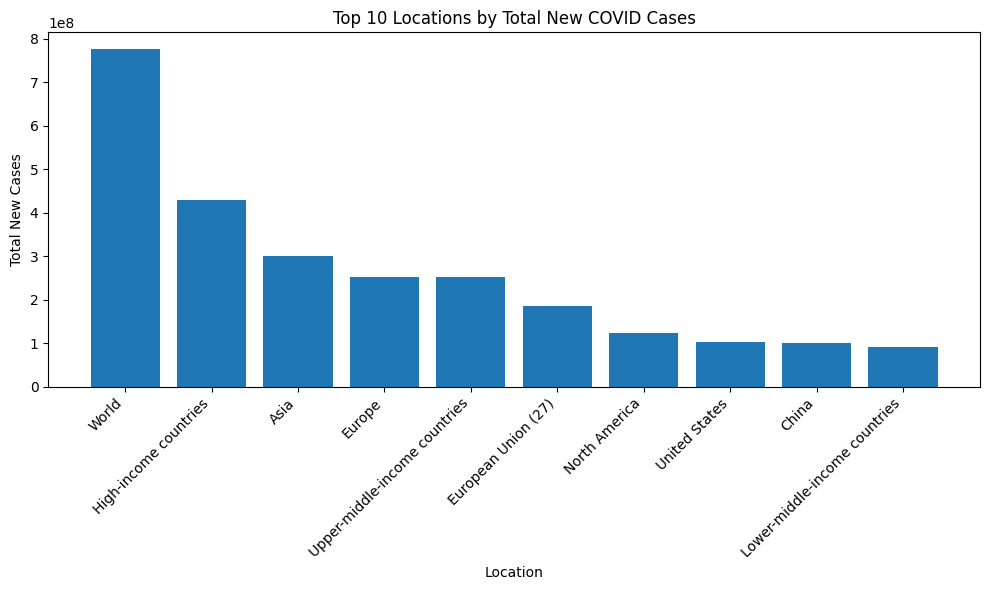

In [8]:
# Group and aggregate with SQL
cases_by_location = spark.sql("""
    SELECT location, SUM(new_cases) AS total_new_cases
    FROM covid_data
    GROUP BY location
    ORDER BY total_new_cases DESC
    LIMIT 10
""")

pdf_cases = cases_by_location.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(pdf_cases["location"], pdf_cases["total_new_cases"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Locations by Total New COVID Cases")
plt.xlabel("Location")
plt.ylabel("Total New Cases")
plt.tight_layout()
plt.show()



# **6. Feature Selection & Correlation**
- We create a subset of columns `(df_numeric)` and convert to Pandas to compute a **correlation matrix**.




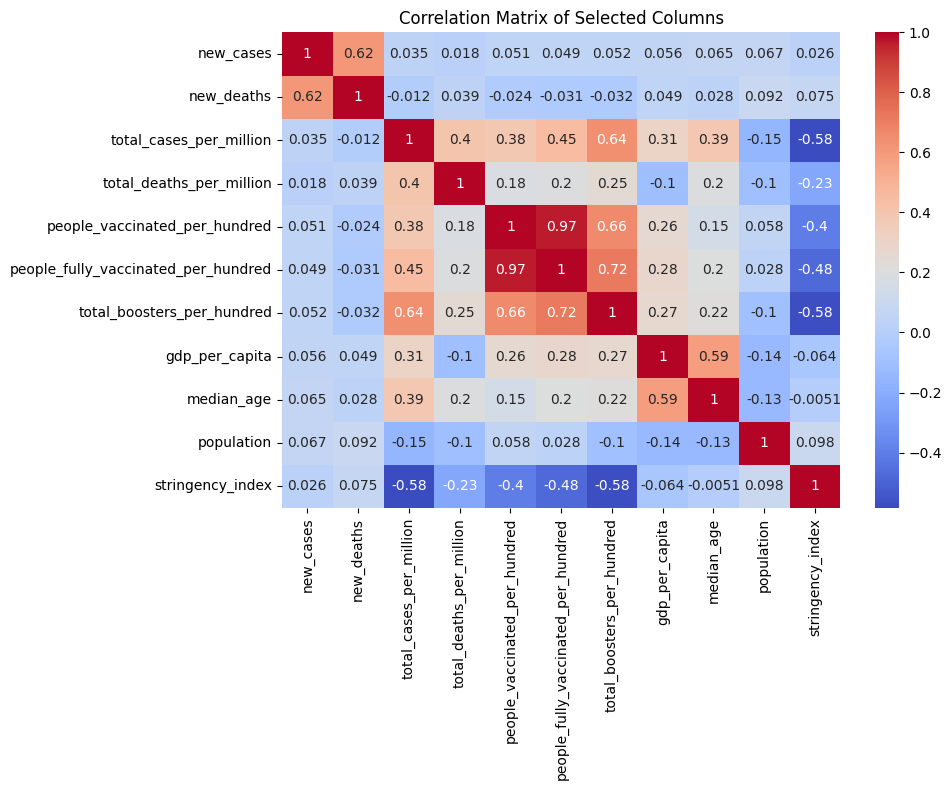

In [9]:
cols_keep = [
    "new_cases", "new_deaths",
    "total_cases_per_million", "total_deaths_per_million",
    "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred",
    "total_boosters_per_hundred", "gdp_per_capita", "median_age",
    "population", "stringency_index"
]

# Create a Spark DF with these columns only
df_numeric = df.select(*cols_keep).na.drop(subset=cols_keep)
pdf_numeric = df_numeric.toPandas()

import seaborn as sns

corr_matrix = pdf_numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Selected Columns")
plt.tight_layout()
plt.show()


# Exploratory Visualizations
### Distribution of Key Columns
- Histograms and KDE plots show the distribution of individual variables.


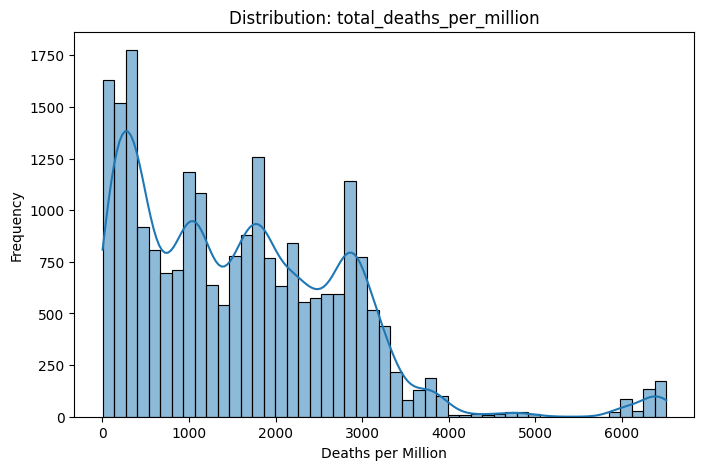

In [10]:
# Distribution of total_deaths_per_million
import numpy as np

plt.figure(figsize=(8,5))
sns.histplot(pdf_numeric["total_deaths_per_million"], kde=True)
plt.title("Distribution: total_deaths_per_million")
plt.xlabel("Deaths per Million")
plt.ylabel("Frequency")
plt.show()

### **Relationship Between Two Key Metrics**
- Scatter plots help visualize the relationship between two variables.


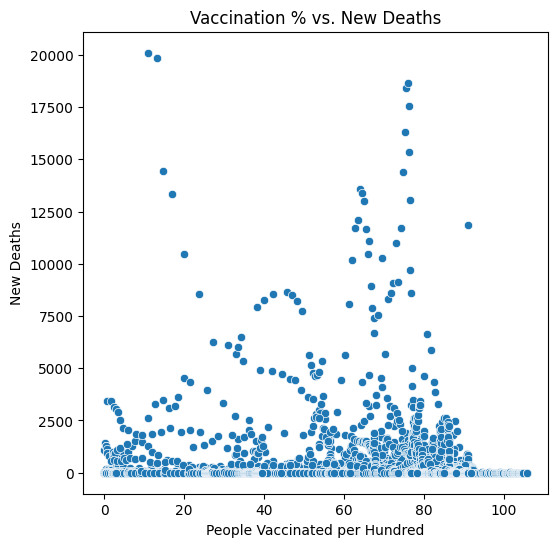

In [11]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=pdf_numeric,
    x="people_vaccinated_per_hundred",
    y="new_deaths"
)
plt.title("Vaccination % vs. New Deaths")
plt.xlabel("People Vaccinated per Hundred")
plt.ylabel("New Deaths")
plt.show()



# **7. Time-Series Visualization**

We demonstrate how to plot:
 - A) Trend of New Cases Over Time
 - B) Trend of Deaths Over Time

We'll filter to a small set of countries (e.g., United States, China, India, Spain)
to make the line chart more readable. We'll group by **date & location**
and sum or average if needed.

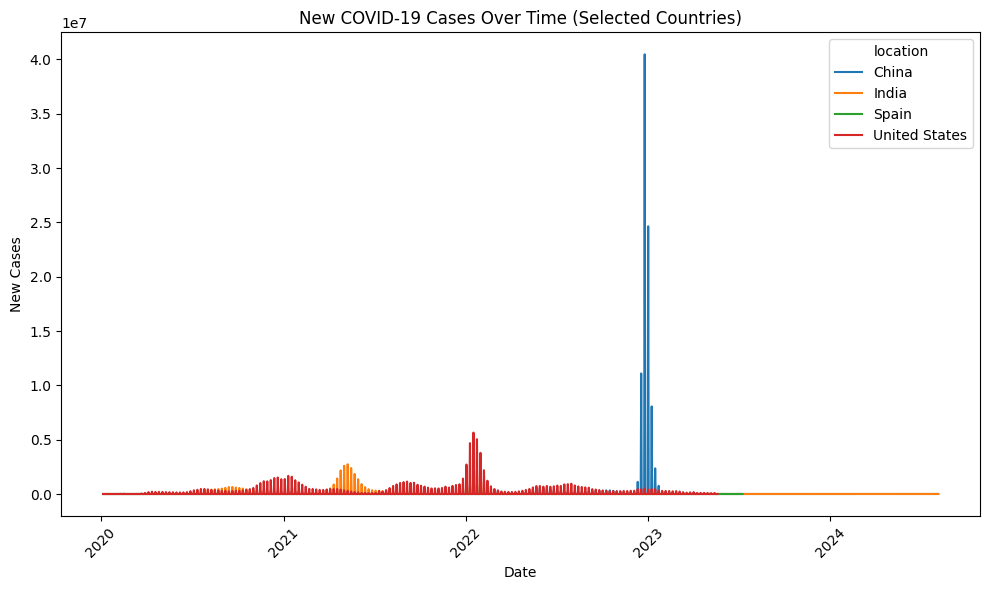

In [12]:
import pandas as pd

countries_of_interest = ["United States", "India", "China", "Spain"]
df_filtered = df.filter(df.location.isin(countries_of_interest))

df_time_cases = df_filtered.select("date", "location", "new_cases").orderBy("date")
pdf_time_cases = df_time_cases.toPandas()

pdf_time_cases["date"] = pd.to_datetime(pdf_time_cases["date"], format="%Y-%m-%d")

plt.figure(figsize=(10,6))
sns.lineplot(data=pdf_time_cases, x="date", y="new_cases", hue="location")
plt.title("New COVID-19 Cases Over Time (Selected Countries)")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **8. Comparisons & Ranking**

- We pick the **maximum date** in the data and display top countries by **total_cases** and **total_deaths**:

Valid rows count: 390042
Max date with valid country-level data: 2024-08-04
pdf_latest shape: (10, 4)
        location  total_cases  total_deaths  population
0  United States    103436829       1193165   338289856
1          China     99373219        122304  1425887360
2          India     45041748        533623  1417173120
3         France     38997490        168091    67813000
4        Germany     38437756        174979    83369840


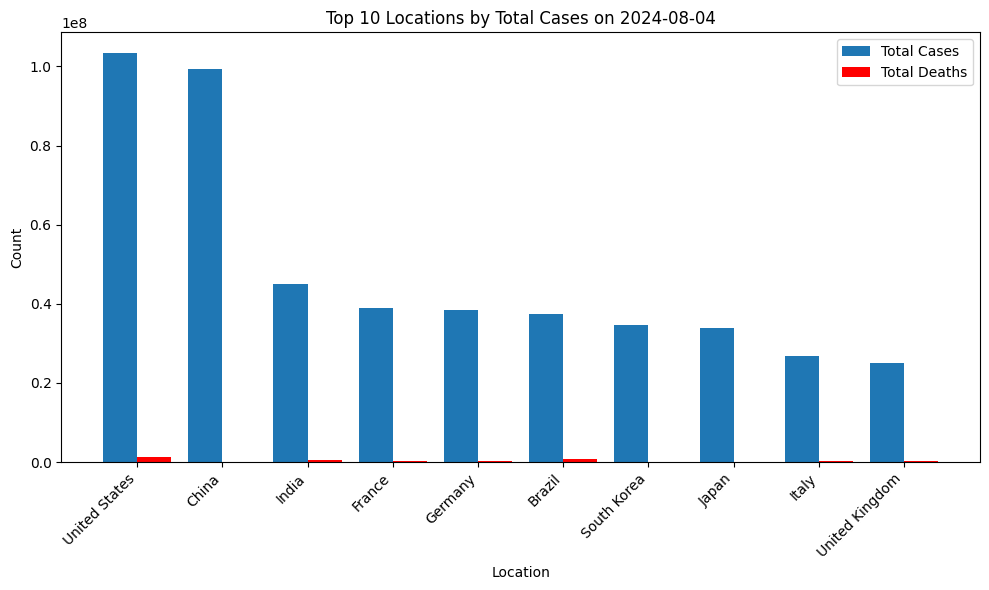

In [13]:
# -------------------------------------------
# Step 1: Filter to Real Countries Only
# -------------------------------------------
df_countries = df.filter(F.length(F.col("iso_code")) == 3)

# -------------------------------------------
# Step 1.1: Further filter to rows with non-null key metrics
# -------------------------------------------
df_valid = df_countries.filter(
    (F.col("total_cases").isNotNull()) &
    (F.col("total_deaths").isNotNull()) &
    (F.col("population").isNotNull())
)

# Check count
print("Valid rows count:", df_valid.count())

# -------------------------------------------
# Step 2: Find the Maximum Date for Valid Country Data
# -------------------------------------------
max_date_valid = df_valid.select(F.max("date")).collect()[0][0]
print("Max date with valid country-level data:", max_date_valid)

# -------------------------------------------
# Step 3: Filter to That Date and Select Relevant Columns
# -------------------------------------------
df_latest = (
    df_valid
    .filter(F.col("date") == max_date_valid)
    .select("location", "total_cases", "total_deaths", "population")
    .na.drop()  # drop any rows with nulls in these columns
    .orderBy(F.desc("total_cases"))
)

# -------------------------------------------
# Step 4: Convert to Pandas and Check the Result
# -------------------------------------------
pdf_latest = df_latest.toPandas().head(10)
print("pdf_latest shape:", pdf_latest.shape)
print(pdf_latest.head())

# -------------------------------------------
# Step 5: Plot the Data if Not Empty
# -------------------------------------------
if pdf_latest.empty:
    print("No country-level data found for date:", max_date_valid)
else:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    x_positions = range(len(pdf_latest))
    plt.bar(x_positions, pdf_latest["total_cases"], width=0.4, label="Total Cases")
    plt.bar([x + 0.4 for x in x_positions], pdf_latest["total_deaths"], width=0.4, color='red', label="Total Deaths")
    plt.xticks([x + 0.2 for x in x_positions], pdf_latest["location"], rotation=45, ha="right")
    plt.title(f"Top 10 Locations by Total Cases on {max_date_valid}")
    plt.xlabel("Location")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()



Max date among real countries: 2024-08-04
Automatically selected top 10 countries based on case fatality ratio:
   location  case_fatality_ratio  vaccinated_ratio
2     India             0.011847            0.6718
5     World             0.009096            0.6493
1    Europe             0.008313            0.6629
3  Malaysia             0.007035            0.8118
0      Asia             0.005430            0.7333
4   Oceania             0.002194            0.6233


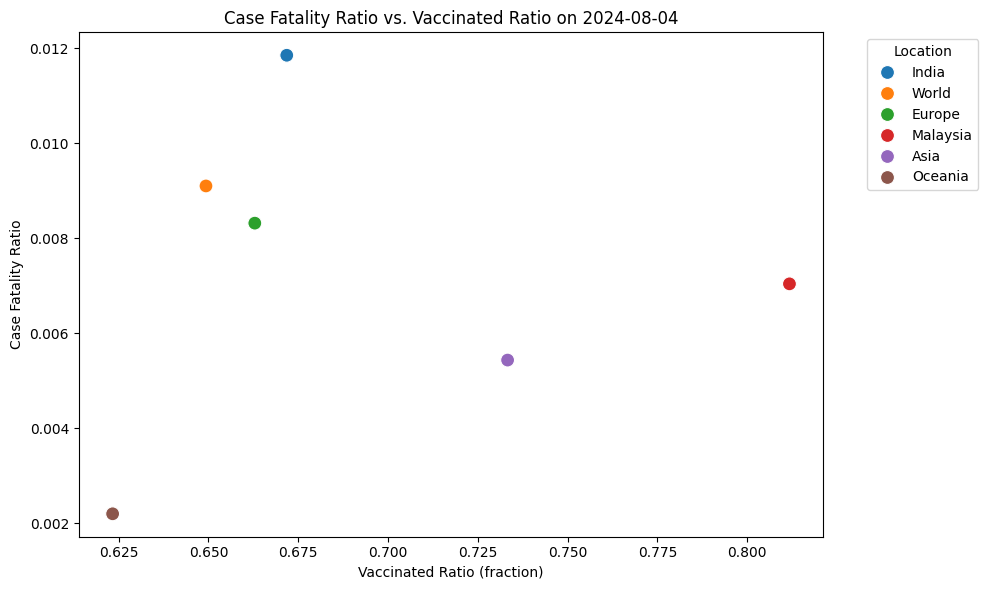

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# -------------------------------------------
# Step 1: Filter to Real Countries and Compute Max Date
# -------------------------------------------
df_countries = df.filter(F.length(F.col("iso_code")) == 3)
# Optionally, you may also want to filter for non-null key metrics:
df_valid = df_countries.filter(
    F.col("total_cases_per_million").isNotNull() &
    F.col("total_deaths_per_million").isNotNull() &
    F.col("people_fully_vaccinated_per_hundred").isNotNull() &
    F.col("population").isNotNull()
)
max_date_countries = df_valid.select(F.max("date")).collect()[0][0]
print("Max date among real countries:", max_date_countries)

# -------------------------------------------
# Option B: Automatically select the top 10 countries by highest case fatality ratio
# Create a feature-engineered DataFrame that includes location, date, and derived metrics
df_feat = (
    df.select(
        "location", "date",
        "total_cases_per_million", "total_deaths_per_million",
        "people_fully_vaccinated_per_hundred", "population"
    ).na.drop(subset=["total_cases_per_million", "total_deaths_per_million", "people_fully_vaccinated_per_hundred", "population"])
    .withColumn(
        "case_fatality_ratio",
        F.when(F.col("total_cases_per_million") > 0,
               F.col("total_deaths_per_million") / F.col("total_cases_per_million"))
         .otherwise(None)
    )
    .withColumn(
        "vaccinated_ratio",
        F.when(F.col("population") > 0,
               F.col("people_fully_vaccinated_per_hundred") / 100.0)
         .otherwise(None)
    )
)

# Filter to the maximum valid date for country-level data
df_case_vacc_all = df_feat.filter(F.col("date") == max_date_countries) \
                           .select("location", "case_fatality_ratio", "vaccinated_ratio") \
                           .na.drop()

# Convert to Pandas
pdf_case_vacc_all = df_case_vacc_all.toPandas()

# Automatically select the top 10 countries based on case fatality ratio (or another criterion)
pdf_top10_case_vacc = pdf_case_vacc_all.sort_values(by="case_fatality_ratio", ascending=False).head(10)

print("Automatically selected top 10 countries based on case fatality ratio:")
print(pdf_top10_case_vacc)

# -------------------------------------------
# Step 2: Plot the Scatter Plot
# -------------------------------------------
if pdf_top10_case_vacc.empty:
    print("No data available for the selected countries on", max_date_countries)
else:
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=pdf_top10_case_vacc,
        x="vaccinated_ratio",
        y="case_fatality_ratio",
        hue="location",
        s=100  # marker size
    )
    plt.title(f"Case Fatality Ratio vs. Vaccinated Ratio on {max_date_countries}")
    plt.xlabel("Vaccinated Ratio (fraction)")
    plt.ylabel("Case Fatality Ratio")
    plt.legend(title="Location", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



# **9. Feature Engineering**
- We create **derived columns** like `case_fatality_ratio` and `vaccinated_ratio`:

In [15]:
from pyspark.sql import functions as F

df_feat = (
    df_numeric
    .withColumn(
        "case_fatality_ratio",
        F.when((F.col("total_cases_per_million") > 0),
               F.col("total_deaths_per_million") / F.col("total_cases_per_million"))
         .otherwise(None)
    )
    .withColumn(
        "vaccinated_ratio",
        F.when((F.col("population") > 0),
               F.col("people_fully_vaccinated_per_hundred") / 100.0)
         .otherwise(None)
    )
)
df_feat.printSchema()



root
 |-- new_cases: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- people_vaccinated_per_hundred: double (nullable = true)
 |-- people_fully_vaccinated_per_hundred: double (nullable = true)
 |-- total_boosters_per_hundred: double (nullable = true)
 |-- gdp_per_capita: double (nullable = true)
 |-- median_age: double (nullable = true)
 |-- population: long (nullable = true)
 |-- stringency_index: double (nullable = true)
 |-- case_fatality_ratio: double (nullable = true)
 |-- vaccinated_ratio: double (nullable = true)



# **10. Binary Classification with Logistic Regression**

### **10.1 Defining the Label**
We define our target variable (label):
  - label = 1:  If `new_cases` > 1000
  - label = 0:  Otherwise


In [16]:
df_class = df_feat.withColumn(
    "label",
    F.when(F.col("new_cases") > 1000, 1).otherwise(0)
)

### **10.2 Assembling the Features**

- We use `VectorAssembler` to combine our feature columns into a single "features" vector, which is required by Spark MLlib's classification algorithms.

- We select columns that actually exist in `df_class`:

In [17]:
from pyspark.ml.feature import VectorAssembler
# List of feature columns to use for classification.  Make sure these columns
# exist and are numeric (or have been preprocessed).
feature_cols_class = [
    "new_deaths",
    "total_cases_per_million",
    "total_deaths_per_million",
    "people_vaccinated_per_hundred",
    "people_fully_vaccinated_per_hundred",
    "total_boosters_per_hundred",
    "gdp_per_capita",
    "median_age",
    "population",
    "stringency_index",
    "case_fatality_ratio",
    "vaccinated_ratio"
]

assembler_class = VectorAssembler(
    inputCols=feature_cols_class,
    outputCol="features"
)

# Transform the DataFrame to include the "features" column
df_class_ml = assembler_class.transform(df_class).select("features","label") \
                            .na.drop(subset=["features","label"])


### **10.3 Train-Test Split**
- We split the data into training (80%) and testing (20%) sets.
- `seed=42` ensures reproducibility.

In [18]:
from pyspark.ml.classification import LogisticRegression

train_data, test_data = df_class_ml.randomSplit([0.8, 0.2], seed=42)
print("Train rows =", train_data.count(), "Test rows =", test_data.count())

Train rows = 18658 Test rows = 4474


### **10.4 Handling Class Imbalance & Setting Threshold**

 - We address class imbalance (likely more days with < 1000 cases than > 1000).
 - We calculate weights for each class inversely proportional to their frequency. This gives more weight to the minority class (label=1) during training.
 - We also set a lower prediction `threshold` (0.3) to be more sensitive to predicting positive cases (days with > 1000 new cases).  This increases recall for the positive class.

In [19]:
counts = train_data.groupBy("label").count().collect()
label_counts = {row["label"]: row["count"] for row in counts}
total_0 = label_counts.get(0, 0)
total_1 = label_counts.get(1, 0)
total = total_0 + total_1

# Calculate weights, handling the case where one class might be absent
w1 = total/(2.0 * total_1) if total_1 > 0 else 1.0
w0 = total/(2.0 * total_0) if total_0 > 0 else 1.0

print(f"Clase=0 => {total_0} rows, Clase=1 => {total_1}, Total={total}")
print(f"Weight(0)={w0}, Weight(1)={w1}")

Clase=0 => 16325 rows, Clase=1 => 2333, Total=18658
Weight(0)=0.5714548238897397, Weight(1)=3.9987141020145733


### **Create class_weight column**

In [20]:
# We add a `class_weight` column to the training data.
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def assign_weight(label):
    return w1 if label == 1 else w0

assign_weight_udf = udf(assign_weight, DoubleType())
train_weighted = train_data.withColumn("class_weight", assign_weight_udf("label"))

train_weighted.show(5)

+--------------------+-----+------------------+
|            features|label|      class_weight|
+--------------------+-----+------------------+
|[0.0,2778.45,53.3...|    0|0.5714548238897397|
|[0.0,2781.14,53.3...|    0|0.5714548238897397|
|[0.0,2792.95,53.3...|    0|0.5714548238897397|
|[0.0,2801.71,53.3...|    0|0.5714548238897397|
|[0.0,2841.5,53.32...|    0|0.5714548238897397|
+--------------------+-----+------------------+
only showing top 5 rows



### **Train & Predict**
- We train a Logistic Regression model with the `weightCol` and `threshold` parameters.


In [21]:
from pyspark.ml.classification import LogisticRegression

# LogisticRegression with weightCol and threshold=0.3
lr_weighted = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="class_weight",
    threshold=0.3
)

lr_weighted_model = lr_weighted.fit(train_weighted)
predictions_weighted = lr_weighted_model.transform(test_data)

predictions_weighted.select("features","label","prediction","probability").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------+-----+----------+-----------------------------------------+
|features                                                                                                  |label|prediction|probability                              |
+----------------------------------------------------------------------------------------------------------+-----+----------+-----------------------------------------+
|[0.0,2787.09,53.32,33.89,17.78,1.04,5819.5,16.8,3.5588996E7,42.3,0.01913106501763488,0.1778]              |0    |0.0       |[0.9339975786775978,0.0660024213224022]  |
|[0.0,2851.13,53.32,37.3,20.31,2.27,5819.5,16.8,3.5588996E7,28.31,0.018701357005818747,0.20309999999999997]|0    |0.0       |[0.892750736978131,0.10724926302186899]  |
|[0.0,2883.2,53.8,39.44,21.67,3.0,5819.5,16.8,3.5588996E7,28.23,0.01865982241953385,0.2167]                |0    |0.0       |[0.8898542727929544,0.1101457272070

### **10.5 Evaluating the Model**
- We evaluate the model using accuracy, confusion matrix, and classification report.
- We focus on recall for the positive class (label=1), as we want to correctly identify days with high case counts.

In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report

pred_df = predictions_weighted.select("label","prediction")

evaluator_acc = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator_acc.evaluate(pred_df)
print("Accuracy =", accuracy)

# Convert to Pandas for scikit-learn metrics
pred_pd = pred_df.toPandas()
cm = confusion_matrix(pred_pd["label"], pred_pd["prediction"])
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(pred_pd["label"], pred_pd["prediction"]))


Accuracy = 0.981001341081806

Confusion Matrix:
 [[3848   62]
 [  23  541]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3910
           1       0.90      0.96      0.93       564

    accuracy                           0.98      4474
   macro avg       0.95      0.97      0.96      4474
weighted avg       0.98      0.98      0.98      4474



### **Interpreting the Results (Example - Adapt to your specific values):**

- Accuracy:  Our model has an accuracy of 98.1%, which seems very high. However, accuracy can be misleading with imbalanced datasets.
- Confusion Matrix: The heatmap shows that the model performs very well on the negative class (label=0, days with <= 1000 cases).  It correctly predicts 3848 out of 3910 such days.  For the positive class (label=1, days with > 1000 cases), it correctly predicts 541 out of 564, which is also good, but there are some errors.

**Classification Report**:
- Precision (label=1): 0.90.  This means that 90% of the days predicted as having > 1000 cases were actually high-case days.
- Recall (label=1): 0.96.  This is the most important metric for our goal.  It means that the model correctly identified 96% of the *actual* high-case days.
- F1-score (label=1): 0.93. A good balance between precision and recall.

**Conclusion So Far:** The model performs very well, particularly in terms of recall for the positive class. It's very good at identifying days with high COVID-19 case counts.


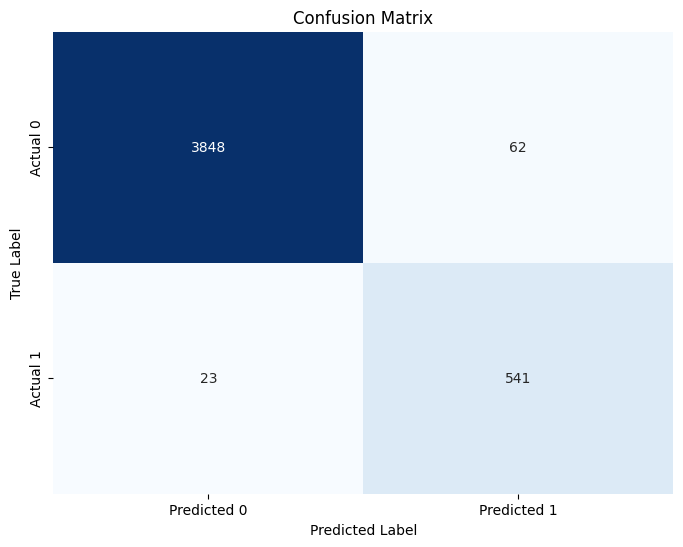

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(pred_pd["label"], pred_pd["prediction"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### **ROC Curve and AUC**
- The ROC curve and AUC provide another way to evaluate the model's performance, especially for imbalanced datasets.

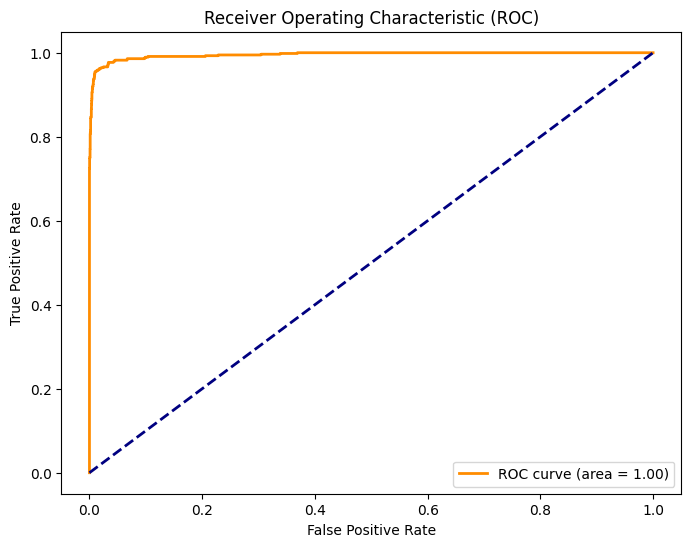

In [24]:
from sklearn.metrics import roc_curve, auc
from pyspark.ml.functions import vector_to_array  # Import vector_to_array

# Extract probabilities for the positive class (index 1)
# Use vector_to_array to convert the probability vector to an array
probabilities = predictions_weighted.select(vector_to_array(predictions_weighted.probability).alias("prob_array"))
positive_probs = probabilities.select(probabilities.prob_array[1].alias("positive_prob")).toPandas()

fpr, tpr, thresholds = roc_curve(pred_pd["label"], positive_probs['positive_prob'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### **Precision-Recall Curve**

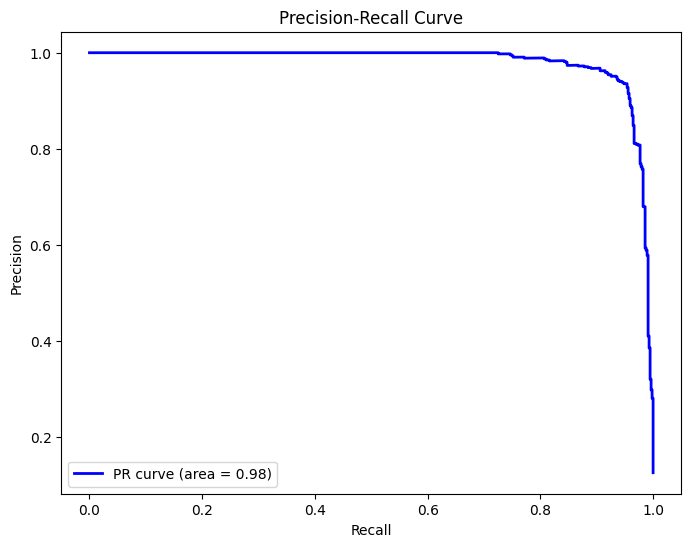

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(pred_pd["label"], positive_probs['positive_prob'])
average_precision = average_precision_score(pred_pd["label"], positive_probs['positive_prob'])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### **Feature Coefficients**

- Let's examine the coefficients of the logistic regression model to get an idea of which features are most influential.  Note that logistic regression coefficients represent the log-odds change, so positive coefficients increase the likelihood of the positive class, and negative coefficients decrease it.

In [26]:
coefficients = lr_weighted_model.coefficients
feature_importance = list(zip(feature_cols_class, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)  # Sort by absolute value
print("Feature Coefficients (Sorted by Magnitude):")
for feature, coef in feature_importance:
    print(f"{feature}: {coef:.3f}")

Feature Coefficients (Sorted by Magnitude):
case_fatality_ratio: -64.978
vaccinated_ratio: 0.935
new_deaths: 0.615
median_age: -0.077
stringency_index: -0.033
total_boosters_per_hundred: -0.014
people_fully_vaccinated_per_hundred: 0.009
people_vaccinated_per_hundred: 0.004
total_deaths_per_million: -0.000
gdp_per_capita: 0.000
total_cases_per_million: -0.000
population: -0.000


- `case_fatality_ratio`:  A large negative coefficient suggests that as the case fatality ratio *increases*, the likelihood of having > 1000 new cases *decreases*.  This might seem counterintuitive, but it could reflect situations where a high fatality ratio is due to limited testing, so the *reported* number of new cases is low, even though the true number of infections might be high. It's also possible this variable isn't very informative for our specific classification task.
- `vaccinated_ratio`: A positive coefficient suggests that a higher vaccination rate is associated with a higher likelihood of having > 1000 new cases. This is likely capturing other underlying factors, and does NOT mean vaccinations cause more cases. It's probably an artifact of the data (e.g., more vaccinated places may also have better testing and reporting). This is an excellent example of why correlation does not equal causation!
- The other coefficients are relatively small, suggesting they have less influence on the prediction.

### **Investigating False Positives and False Negatives**
- It's valuable to examine the cases where the model made mistakes.

In [27]:
false_positives = predictions_weighted.filter((F.col("prediction") == 1) & (F.col("label") == 0))
false_negatives = predictions_weighted.filter((F.col("prediction") == 0) & (F.col("label") == 1))

print("False Positives:")
false_positives.show()

print("False Negatives:")
false_negatives.show()

False Positives:
+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,76352.25,26....|    0|[0.80434311127580...|[0.69090274738923...|       1.0|
|[0.0,76755.62,26....|    0|[0.80610922757206...|[0.69127978515136...|       1.0|
|[0.0,78649.54,26....|    0|[0.82167122015270...|[0.69459097855803...|       1.0|
|[0.0,79047.79,26....|    0|[0.82314468187879...|[0.69490346075295...|       1.0|
|[0.0,79353.83,26....|    0|[0.71690953477648...|[0.67192611287895...|       1.0|
|[0.0,79515.19,26....|    0|[0.76263618410670...|[0.68192580406294...|       1.0|
|[2.0,11532.36,171...|    0|[0.82595609697146...|[0.69549918946702...|       1.0|
|[3.0,133926.67,11...|    0|[-0.9802953577454...|[0.27283318215752...|       1.0|
|[4.0,11522.69,171...|    0|[-0.4048289169145...|[0.40015269559568...|       1.0|

# **Time-Series Analysis of Predictions**

+------+------------------------------------------------------------------------------------------------------------+-----+
|row_id|features                                                                                                    |label|
+------+------------------------------------------------------------------------------------------------------------+-----+
|0     |[0.0,65192.75,1028.78,36.07,31.62,0.1,11803.43,38.0,2842318.0,40.74,0.015780589099248,0.31620000000000004]  |0    |
|1     |[0.0,65192.75,1028.78,36.29,31.84,0.29,11803.43,38.0,2842318.0,40.74,0.015780589099248,0.3184]              |0    |
|2     |[39.0,66485.01,1042.58,36.32,31.87,0.31,11803.43,38.0,2842318.0,40.74,0.015681429543291037,0.3187]          |1    |
|3     |[0.0,66485.01,1042.58,36.5,32.05,0.53,11803.43,38.0,2842318.0,46.3,0.015681429543291037,0.32049999999999995]|0    |
|4     |[0.0,66485.01,1042.58,36.59,32.14,0.65,11803.43,38.0,2842318.0,46.3,0.015681429543291037,0.3214]            |0    |
+------+

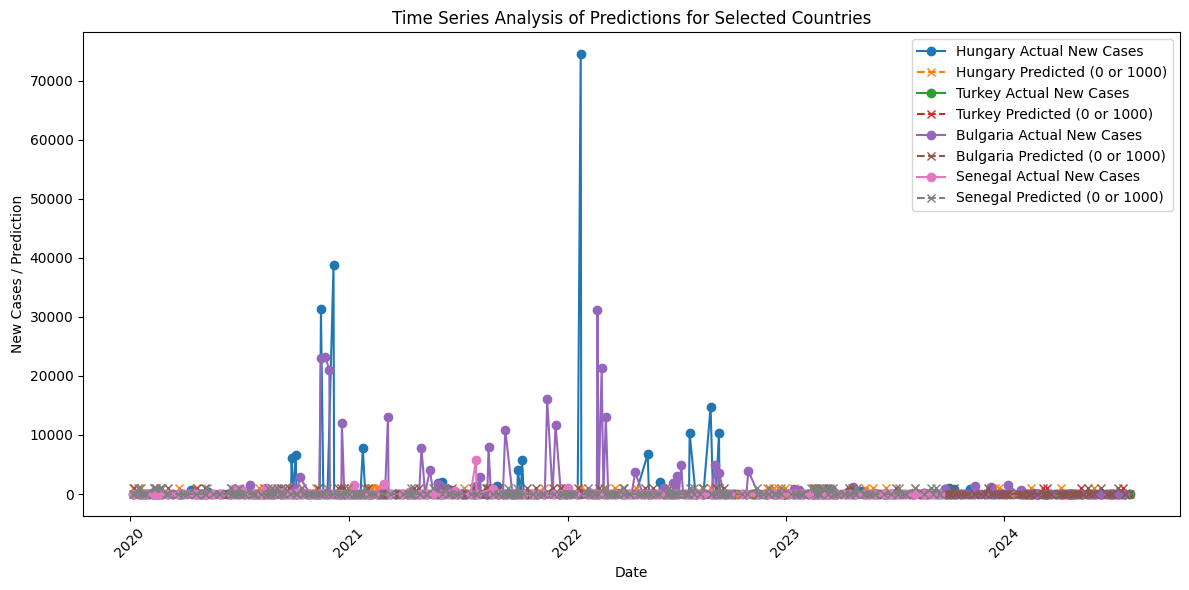

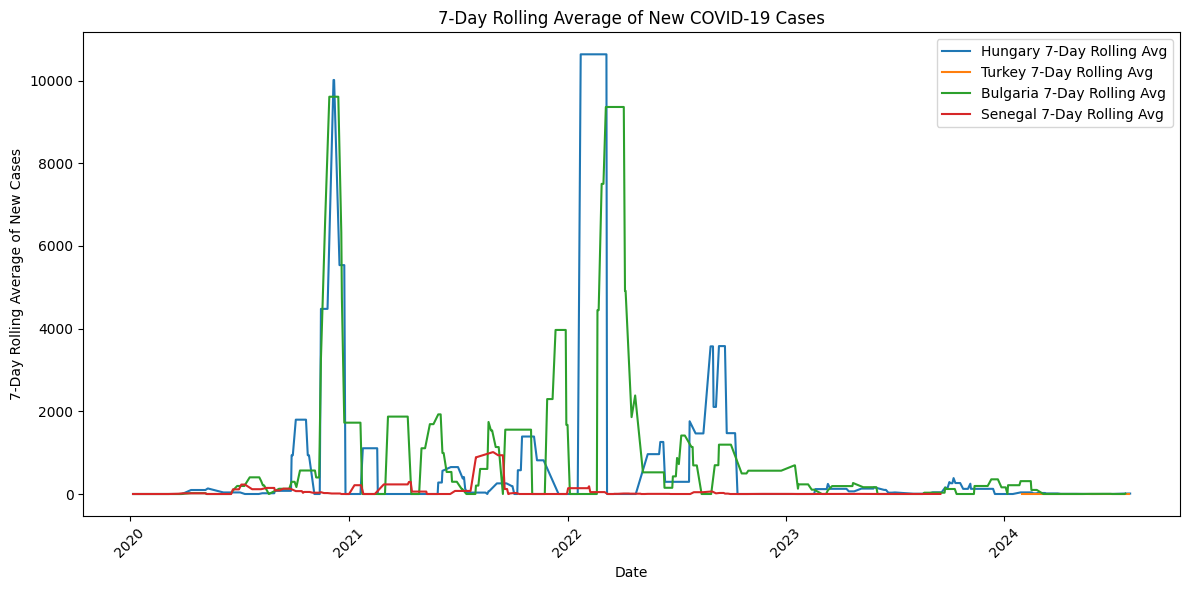

<ipython-input-35-70a68a411bc1>:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_time_filtered["error"] = pdf_time_filtered["new_cases"] - (pdf_time_filtered["prediction"] * 1000)


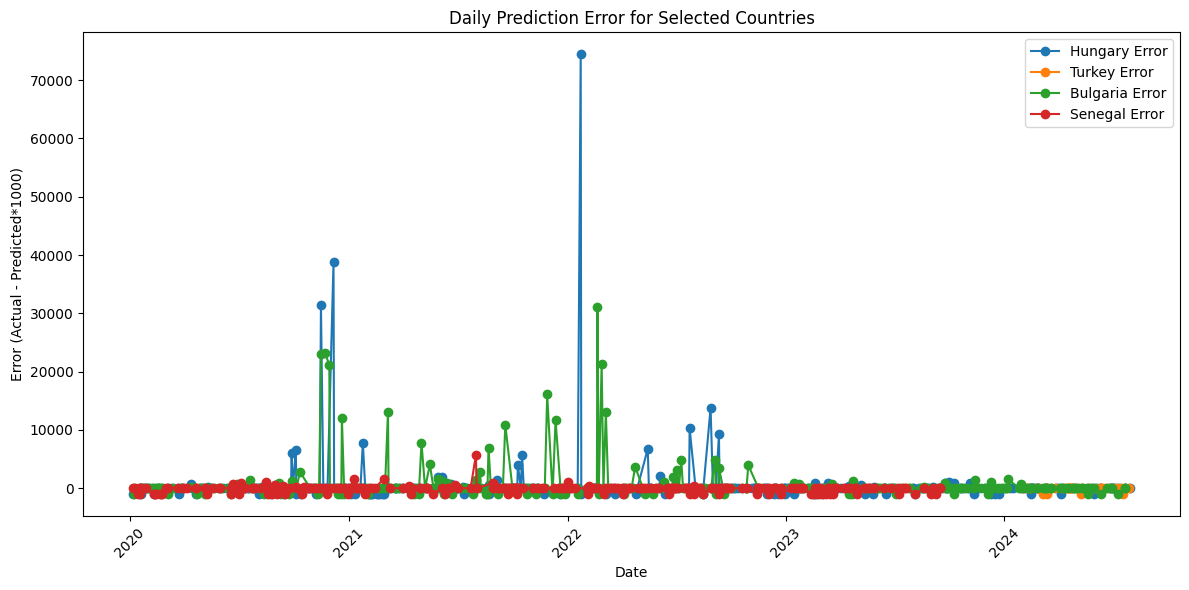

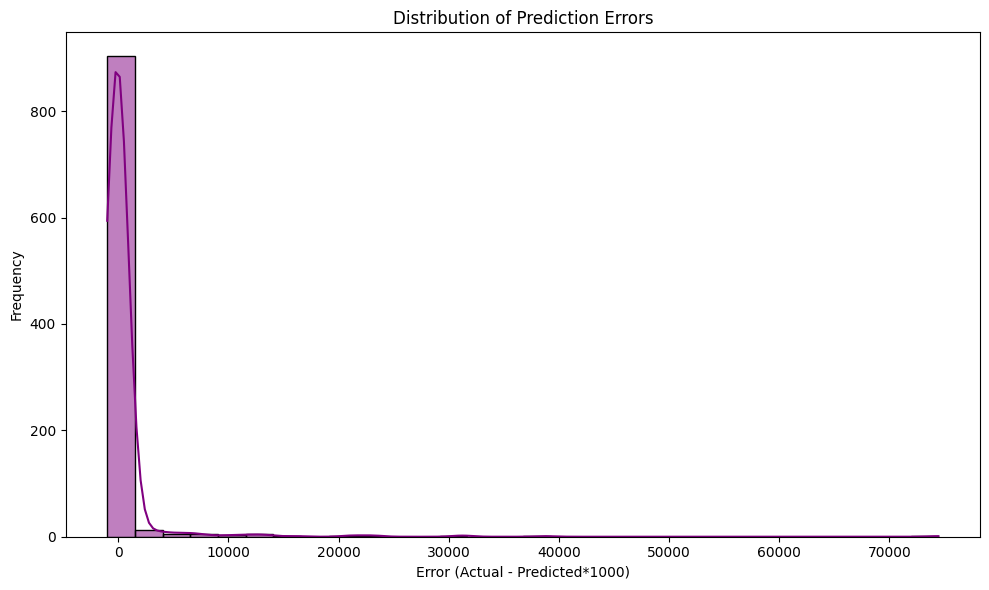

False Positives:
+----------+------------+---------+----------+-----------------------------------------+
|date      |location    |new_cases|prediction|probability                              |
+----------+------------+---------+----------+-----------------------------------------+
|2023-05-30|Afghanistan |0        |1.0       |[6.40745974792373E-4,0.9993592540252076] |
|2023-06-06|Afghanistan |0        |1.0       |[0.5082067171248658,0.49179328287513424] |
|2024-06-15|Afghanistan |0        |1.0       |[0.4001526955956822,0.5998473044043178]  |
|2024-07-02|Afghanistan |0        |1.0       |[0.6954991894670216,0.3045008105329784]  |
|2021-12-15|Africa      |0        |1.0       |[0.6909027473892311,0.3090972526107689]  |
|2021-12-18|Africa      |0        |1.0       |[0.6912797851513693,0.30872021484863066] |
|2021-12-24|Africa      |0        |1.0       |[0.6945909785580396,0.30540902144196036] |
|2021-12-25|Africa      |0        |1.0       |[0.6949034607529533,0.3050965392470467]  |
|202

In [35]:
# =============================================================================
# Step 0: Ensure your Feature DataFrame (df_class_ml) includes a unique row_id.
# =============================================================================
# Assume df_class_ml has been created using VectorAssembler and contains "features" and "label".
df_class_ml_with_id = df_class_ml.withColumn("row_id", monotonically_increasing_id())
df_class_ml_with_id.select("row_id", "features", "label").show(5, truncate=False)

# =============================================================================
# Step 1: Split the Data into Training and Testing Sets.
# =============================================================================
train_data, test_data = df_class_ml_with_id.randomSplit([0.8, 0.2], seed=42)
print("Train rows =", train_data.count(), "Test rows =", test_data.count())

# =============================================================================
# Step 2: Calculate Class Weights and Train the Model.
# =============================================================================
counts = train_data.groupBy("label").count().collect()
label_counts = {row["label"]: row["count"] for row in counts}
total_0 = label_counts.get(0, 0)
total_1 = label_counts.get(1, 0)
total = total_0 + total_1

w1 = total / (2.0 * total_1) if total_1 > 0 else 1.0
w0 = total / (2.0 * total_0) if total_0 > 0 else 1.0

print(f"Clase=0 => {total_0} rows, Clase=1 => {total_1} rows, Total = {total}")
print(f"Weight(0) = {w0}, Weight(1) = {w1}")

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def assign_weight(label):
    return w1 if label == 1 else w0

assign_weight_udf = udf(assign_weight, DoubleType())
train_weighted = train_data.withColumn("class_weight", assign_weight_udf("label"))
train_weighted.show(5, truncate=False)

from pyspark.ml.classification import LogisticRegression

lr_weighted = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="class_weight",
    threshold=0.3  # Lower threshold to capture more high-case days
)

lr_weighted_model = lr_weighted.fit(train_weighted)

# =============================================================================
# Step 3: Generate Predictions on Test Data.
# =============================================================================
predictions_weighted = lr_weighted_model.transform(test_data)
# The test set already has row_id because it came from df_class_ml_with_id.
predictions_for_join = predictions_weighted.select("row_id", "prediction")
predictions_for_join.show(5, truncate=False)

# =============================================================================
# Step 4: Prepare the Original Data for Time-Series Analysis.
# =============================================================================
# Select relevant columns from the original df.
df_for_time_series = df.select("date", "location", "new_cases", "iso_code")
# Filter to real countries (iso_code length == 3)
df_for_time_series = df_for_time_series.filter(F.length(F.col("iso_code")) == 3)

# Add a row_id to the original df so we can join later.
df_original_with_id = df.withColumn("row_id", monotonically_increasing_id())

# Join df_for_time_series with df_original_with_id to obtain the row_id.
df_filtered_for_join = df_for_time_series.join(
    df_original_with_id.select("date", "location", "iso_code", "new_cases", "row_id"),
    on=["date", "location", "iso_code", "new_cases"],
    how="left"
).join(
    test_data.select("row_id"),
    on="row_id",
    how="inner"
)

# Now join the predictions with the filtered original data.
df_time_analysis = df_filtered_for_join.join(predictions_for_join, "row_id", "inner")
df_time_analysis.show(5, truncate=False)

# =============================================================================
# Step 5: Convert to Pandas and Plot Time Series.
# =============================================================================
pdf_time_analysis = (df_time_analysis.select("date", "location", "new_cases", "prediction")
                     .orderBy("date")
                     .toPandas())

pdf_time_analysis["date"] = pd.to_datetime(pdf_time_analysis["date"], format="%Y-%m-%d")

# Print unique locations in the time-series analysis
print("Unique location values in pdf_time_analysis:")
print(pdf_time_analysis["location"].unique())

# Since "United States" is not available, choose available countries:
selected_countries = ["Hungary", "Turkey", "Bulgaria", "Senegal"]

pdf_time_filtered = pdf_time_analysis[pdf_time_analysis["location"].isin(selected_countries)]

if pdf_time_filtered.empty:
    print("No data available for the selected countries on the chosen date range.")
else:
    # --- Visualization 1: Actual vs. Predicted Time Series ---
    plt.figure(figsize=(12, 6))
    for country in selected_countries:
        country_data = pdf_time_filtered[pdf_time_filtered["location"] == country]
        plt.plot(country_data["date"], country_data["new_cases"], marker="o", label=f"{country} Actual New Cases")
        # Scale binary predictions (0 or 1) by 1000 for visualization purposes.
        plt.plot(country_data["date"], country_data["prediction"] * 1000, linestyle='--', marker="x", label=f"{country} Predicted (0 or 1000)")
    plt.xlabel("Date")
    plt.ylabel("New Cases / Prediction")
    plt.title("Time Series Analysis of Predictions for Selected Countries")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Visualization 2: Rolling 7-Day Average of Actual New Cases ---
    pdf_time_filtered_sorted = pdf_time_filtered.sort_values(["location", "date"])
    plt.figure(figsize=(12, 6))
    for country in selected_countries:
        country_data = pdf_time_filtered_sorted[pdf_time_filtered_sorted["location"] == country].copy()
        # Compute a 7-day rolling average (min_periods=1 to include early days).
        country_data["rolling_avg"] = country_data["new_cases"].rolling(window=7, min_periods=1).mean()
        plt.plot(country_data["date"], country_data["rolling_avg"], label=f"{country} 7-Day Rolling Avg")
    plt.xlabel("Date")
    plt.ylabel("7-Day Rolling Average of New Cases")
    plt.title("7-Day Rolling Average of New COVID-19 Cases")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Visualization 3: Daily Prediction Error ---
    # Compute error as: actual new_cases - (prediction * 1000)
    pdf_time_filtered["error"] = pdf_time_filtered["new_cases"] - (pdf_time_filtered["prediction"] * 1000)
    plt.figure(figsize=(12, 6))
    for country in selected_countries:
        country_data = pdf_time_filtered[pdf_time_filtered["location"] == country]
        plt.plot(country_data["date"], country_data["error"], marker="o", label=f"{country} Error")
    plt.xlabel("Date")
    plt.ylabel("Error (Actual - Predicted*1000)")
    plt.title("Daily Prediction Error for Selected Countries")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Visualization 4: Histogram of Prediction Errors ---
    plt.figure(figsize=(10,6))
    sns.histplot(pdf_time_filtered["error"], bins=30, kde=True, color='purple')
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Error (Actual - Predicted*1000)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# =============================================================================
# Step 6: Investigate False Positives and False Negatives
# =============================================================================
false_positives = predictions_weighted.filter((F.col("prediction") == 1) & (F.col("label") == 0)) \
                                      .join(df_original_with_id, "row_id", "inner")
false_negatives = predictions_weighted.filter((F.col("prediction") == 0) & (F.col("label") == 1)) \
                                      .join(df_original_with_id, "row_id", "inner")

print("False Positives:")
false_positives.select("date", "location", "new_cases", "prediction", "probability").show(truncate=False)

print("False Negatives:")
false_negatives.select("date", "location", "new_cases", "prediction", "probability").show(truncate=False)

# =============================================================================
# Step 7: Feature Coefficients Analysis
# =============================================================================
coefficients = lr_weighted_model.coefficients
feature_importance = list(zip(feature_cols_class, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)
print("Feature Coefficients (Sorted by Magnitude):")
for feature, coef in feature_importance:
    print(f"{feature}: {coef:.3f}")


### **Time-Series Analysis of Predictions**

After training our binary classifier—which predicts whether a given day’s new COVID-19 cases exceed 1000—we performed an in-depth time-series analysis to understand how the model’s predictions compare with the actual data across different countries. Our approach included:

- **Actual vs. Predicted Time Series**:
We plotted the daily new cases along with the model’s binary predictions (scaled by 1000 for visualization purposes) for a set of selected countries (e.g., Hungary, Turkey, Bulgaria, Senegal). This visualization allowed us to see the model’s performance over time and verify that it correctly flags high-case days.

- **Rolling 7-Day Average**:
To smooth out the day-to-day variability and better capture trends, we computed and plotted a 7-day rolling average of the actual new cases. This helps in visualizing underlying trends that might be obscured by daily fluctuations.

- **Daily Prediction Error**:
We calculated the error for each day as the difference between the actual new cases and the scaled prediction (i.e., prediction * 1000). Plotting these errors over time gives us insights into the model’s bias—where it tends to overpredict or underpredict.

- **Error Distribution**:
Finally, we plotted a histogram of the prediction errors to examine their distribution. This is useful for understanding the overall performance of the model and identifying any systematic deviations.

# **11. Conclusion**

- **Objective**: We built a binary classifier to decide if a given day’s new COVID-19 cases exceed 1000 or not. This approach helps to quickly flag days with potential surges in cases.
- **EDA & Feature Engineering**: Through exploratory data analysis using both DataFrame operations and Spark SQL, we identified key metrics and engineered new features—such as the case fatality ratio and vaccinated ratio—to enrich our dataset. These steps enabled us to better understand the relationships between different variables.
- **Handling Class Imbalance**: To improve the model’s ability to detect days with >1000 cases (the minority class), we applied class weighting and adjusted the classification threshold. Our evaluation metrics, including high accuracy (98% or more) and strong recall for the minority class, indicate that the model effectively captures high-case days.
- **Time-Series Insights**: The additional time-series visualizations allowed us to compare the actual data with the model’s predictions over time for selected countries. This analysis not only validated our model’s performance but also provided valuable insights into the temporal trends of COVID-19 cases.

**Next Steps**:

  - **Enhance Feature Engineering**:
Consider adding lag features (e.g., previous day’s cases), additional testing metrics, or hospital capacity data to further improve the model’s predictive power.
  - **Hyperparameter Tuning**:
Employ techniques such as cross-validation to optimize model parameters (e.g., regularization, threshold, class weights).
  - **Time-Series Forecasting**:
If the objective shifts to forecasting the exact number of cases rather than a binary threshold, exploring time-series models (ARIMA, Prophet, RNNs) would be a logical next step.

With this **pipeline—ingesting** data, exploring with **EDA**, **engineering features**, and **training** a classification model—we have a robust framework for analyzing **COVID-19 data** at scale using PySpark. The approach can be adapted for other thresholds or health metrics, giving valuable insights into pandemic trends and alert conditions.